<a href="https://colab.research.google.com/github/Rainforest23/ConnectX_RL/blob/main/kaggle_connectX_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **강화학습 공부 정리** ###

* kaggle의 connect X문제 정의하고 코드 리뷰하기
* 학교에서 배운 알고리즘들을 가지고 connectX를 play하게 하여 알고리즘별 성능 비교해보기
  * Q-learning
  * SARSA
  *Monte Carlo
  *DQN

# 개요

### 1. Kaggle 코드 리뷰
  * kaggle 4개 course 코드 리뷰

### 2. 강화학습 이론 비교 분석
  * ConectFourGym 문제정의
  * 알고리즘

In [ ]:
!pip install kaggle


In [ ]:
!pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1

In [ ]:
!git clone https://github.com/Kaggle/learntools.git
!mv learntools learntools_dir
!mv learntools_dir/learntools learntools
from learntools.deep_learning import decode_predictions

Cloning into 'learntools'...
remote: Enumerating objects: 18539, done.
remote: Counting objects: 100% (919/919), done.
remote: Compressing objects: 100% (485/485), done.
remote: Total 18539 (delta 545), reused 786 (delta 433), pack-reused 17620
Receiving objects: 100% (18539/18539), 105.16 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (13657/13657), done.


In [ ]:
!pip install kaggle-environments

In [ ]:
!pip install gym

In [ ]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
from random import choice
from tqdm.notebook import tqdm
from kaggle_environments import evaluate, make
from collections import defaultdict

# 1. Kaggle 코드 리뷰

# Course 1. Play the Game

## Setup

* kaggle_environments 라이브러리를 이용.
  * env 객체로 하여금 Connect Four 게임 환경을 만듦.
  * make(): connect Four 게임 환경 생성. debug=True로 설정해 에이전트가 실행 중에 발생하는 오류 메시지를 표시.
  * run(): 매개변수로 받은 에이전트.
  * render(): 보드의 현재 상태와 플레이어의 움직임을 보여줌.


In [ ]:
from kaggle_environments import make, evaluate

env = make("connectx", debug=True)

env.run(["random", "random"]) #['random', 'negamax']

env.render(mode="ipython")

## Defining agent

에이전트가 수를 둘 곳 정하기

1. agent_random()
* python 컨프리핸션을 이용하여 게임판의 각 열이 유효하면(수를 놓을 수 있게 비어있다면), 유효한 열을 valid_moves에 리스트 형태로 저장한다.
* return 값은 리스트 중에 랜덤으로 수를 둘 열을 선택

2. agent_middle()
* 무조건 columns의 중간 열을 수를 둠.

3. agent_leftmost()
* 1번과 같이 valid_moves의 리스트를 얻었다면 함수는 가장 왼쪽의 유효한 열을 선택하는 전략을 사용.

In [ ]:
def agent_random(obs, config):
    valid_moves = [col for col in range(config.columns) if obs.board[col] == 0]
    return random.choice(valid_moves)

def agent_middle(obs, config):
    return config.columns//2

def agent_leftmost(obs, config):
    valid_moves = [col for col in range(config.columns) if obs.board[col] == 0]
    return valid_moves[0]

## Evaluating agents

In [ ]:
env.run([agent_leftmost, agent_random])

env.render(mode="ipython")

In [ ]:
get_win_percentages(agent1=agent_middle, agent2=agent_random)

get_win_percentages(agent1=agent_leftmost, agent2=agent_random)

env객체에 run 멤버함수를 사용하여 agent_leftmost()형식으로 수를 두는 에이전트와 agent_random()형식으로 수를 두는 에이전트를 play하도록 한다.


렌더링 된 영상을 보면 leftmost()하는 에이전트가 빠르게 승리를 하게 되는데 이는 어떤 에이전트가 승률이 좋은지 판단하기 부족하다. 그래서 다음과 같이 앞에서 비교한 수를 높는 방식 3가지를 *get_win_percentages()*를 이용하여 비교해보았다.


1. agent_middle() 에이전트와 agent_random() 에이전트 비교
* agent 2의 승률이 0으로 극단적으로 나오고 agent1의 유효하지 않는 플레이가 35로 나왔으므로 무조건 agent_middle()방식으로 수를 두는 것은 승률이 좋다고 판단하기 이르다.

2. agent_leftmost() 에이전트와 agent_random() 에이전트 비교
* 두 에이전트 간 승률이 1번과 비교했을 때 극단적으로 편향되지 않았고, 유효하지 않은 플레이도 0이므로 1번인 middle로 수를 놓는 에이전트보다 leftmost로 수를 놓는 에이전트가 더 좋은 성능을 가졌다 말할 수 있다.


# Course 2. One-Step-Lookahead

주어진 보드판에 특정 state에 오면 보상을 더 주거나 패널티를 주는 reward 체계를 만들면서 agent가 승리하도록 유도 한다.

In [ ]:
# 휴리스틱을 이용하여 scroe을 얻는 함수
def score_move(grid, col, mark, config):
    next_grid = drop_piece(grid, col, mark, config)
    score = get_heuristic(next_grid, mark, config) #업데이트 된 S를 반영하여 reward를 얻음
    return score

# 에이전트 수를 두고 바뀐 보드판을 반환함.
def drop_piece(grid, col, mark, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = mark
    return next_grid

# reward를 얻는 휴리스틱을 이용하여 scroe를 반환하는 함수
def get_heuristic(grid, mark, config):
    num_threes = count_windows(grid, 3, mark, config)
    num_fours = count_windows(grid, 4, mark, config)
    num_threes_opp = count_windows(grid, 3, mark%2+1, config)
    score = num_threes - 1e2*num_threes_opp + 1e6*num_fours
    return score

#Connect X개가 연결 되었는지 확인 하는 함수. X개가 빙고면 True반환
def check_window(window, num_discs, piece, config):
    return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)

#연결된 X가 되기 위해 몇개 수를 둬야 하는지 알려주는 함수(게임의 rule에 맞게 가로,세로,양의 대각선,음의 대각선 4개로 check)
def count_windows(grid, num_discs, piece, config):
    num_windows = 0
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows

In [ ]:
#agent를 정의하는 함수. agent가 어디에 수를 놓을지 그리디하게 선택함
def agent(obs, config):
    # 수를 둘 수 있는 곳의 인덱스를 리스트로 반환
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    # 보드판을 2D로 전환
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    # reward를 얻는 휴ꈰ스틱을 이용하여 score를 반환
    scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, config) for col in valid_moves]))
    # reward를 최대로 받을 수 있는 유효한 인덱스를 리스트로 반환
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]

    return random.choice(max_cols)

In [ ]:
from kaggle_environments import make, evaluate

#Environment의 game 환경을 만듦
env = make("connectx")

# agent와 random 에이전트가 서로 게임을 플레이하는 함수
env.run([agent, "random"])

# 플레이 되는 게임판을 display함.
env.render(mode="ipython")

In [ ]:
# agent의 승률과 또는 agent의 유효하지 않는 플레이 개수
def get_win_percentages(agent1, agent2, n_rounds=100):
    # 기본 환경 셋팅을 config에 딕셔너리로 지정
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # agent 1이 play했을 때 승률 평가
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # agent 2이 play했을 때 승률 평가
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

get_win_percentages(agent1=agent, agent2="random")

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 0.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


# Course 3. N-Step-Lookahead

In [ ]:
#수를 두면서 그때 reward를 minimax
def score_move(grid, col, mark, config, nsteps):
    next_grid = drop_piece(grid, col, mark, config)
    score = minimax(next_grid, nsteps-1, False, mark, config)
    return score

# agent가 Connect X를 했는지 검사: 종료 조건 (X=4이므로 4개의 수가 연달아 있다면 True)
def is_terminal_window(window, config):
    return window.count(1) == config.inarow or window.count(2) == config.inarow

# play의 종료 검사 함수
def is_terminal_node(grid, config):
    # 무승부 확인
    if list(grid[0, :]).count(0) == 0:
        return True
    # Check for win: horizontal, vertical, or diagonal

    # 가로로 승리 조건 검사
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if is_terminal_window(window, config):
                return True
    # 세로로 승리 조건 검사
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if is_terminal_window(window, config):
                return True
    # 양의 대각선 승리 조건 검사
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    # 음의 대각선 승리 조건 검사
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    return False

# minimax 함수: 두 플레이어가 완벽하게 게임을 플레이할 때 예상되는 최적의 게임 플레이를 계산
def minimax(node, depth, maximizingPlayer, mark, config):
    is_terminal = is_terminal_node(node, config)
    valid_moves = [c for c in range(config.columns) if node[0][c] == 0]
    if depth == 0 or is_terminal:
        return get_heuristic(node, mark, config)
    if maximizingPlayer: # agent가 자신의 승리를 극대화 하려고 가능한 모든 수를 고려 최대 가치를 갖는 수의 index 선택
        value = -np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark, config)
            value = max(value, minimax(child, depth-1, False, mark, config))
        return value
    else:
        value = np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark%2+1, config)
            value = min(value, minimax(child, depth-1, True, mark, config))
        return value

In [ ]:
# 게임 트리의 깊이
N_STEPS = 3

# agent를 정의하는 함수
def agent(obs, config):
    # 수를 둘 수 있는 유효한 col의 index를 리스트로 반환
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    # 게임판 2D 전환
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    # 다음판에서 기대할 수 있는 reward 반환
    scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, config, N_STEPS) for col in valid_moves]))
    #승률을 최대화 할 수 있는 index 반환
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    # maxmini하게 해주는 수의 인덱스를 랜덤 반환
    return random.choice(max_cols)

In [ ]:
from kaggle_environments import make, evaluate

#Environment의 game 환경을 만듦
env = make("connectx")

# agent와 random 에이전트가 서로 게임을 플레이하는 함수
env.run([agent, "random"])

# 플레이 되는 게임판을 display함.
env.render(mode="ipython")

In [ ]:
get_win_percentages(agent1=agent, agent2="random", n_rounds=50)

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 0.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


# Course 4. Deep Reinforcement Learning

###class ConnectFourGym

* ConnectFour 게임을 OpenAi의 Gym이라는 형태로 로딩
*__init__(): 초기화 함수
* reset(): 객체의 s,a,r,s를 초기화 해준다.
* change_reward(): agent가 다음 수를 두면서 얻게 되는 reward를 정의
  * 에이전트가 이기면 +1, 지면 -1, 그 외의 경우에는 1/42의 보상을 제공합니다.
* step(): 에이전트가 선택한 행동을 실행하고 그 결과를 반환하는 함수
  * 유효한 행동 -> 환경의 step메서드 호출. 보상을 change_reward로 받음.
  * 유효 하지 않은 행동 -> 게임 종료. 최고의 패널티 -10

* ***env.step():***

  * board: 현재 state
  * old reward: 현재 state 이후 받은 reward
  * done: terminated/truncated
  * terminated=True if environment terminates (eg. due to task completion, failure etc.)
  * truncated=True if episode truncates due to a time limit or a reason that is not defined as part of the task MDP.
  * _ : info

In [ ]:
class ConnectFourGym(gym.Env):
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True) # 에이전트가 훈련할 수 있는 kaggle 환경의 훈련 버전 저장

        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows # 게임의 초기값 row 할당
        self.columns = ks_env.configuration.columns #게임의 초기값 col 할당

        self.action_space = spaces.Discrete(self.columns) # 게임의 action을 정의
        self.observation_space = spaces.Box(low=0, high=2, # 게임의 observation 정의
                                            shape=(1,self.rows,self.columns), dtype=int)

        self.reward_range = (-10, 1) # 보상 체계: -10부터 1까지 범위 지정

        # StableBaselines error 처리
        self.spec = None
        self.metadata = None


    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns) # self.obs['board']는 게임 보드의 현재 상태를 나타내며, 이를 NumPy 배열로 변환하여 반환

    def change_reward(self, old_reward, done):
        if old_reward == 1: # 이겼을 때
            return 1
        elif done: # 졌을 때(상태가 이겼을 때)
            return -1
        else: # 그 외 경우
            return 1/(self.rows*self.columns)

    def step(self, action):
        # 유효한 수를 둘 indiex가 있는지 확인 bool형
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # 다음 수를 두기
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # 유효하지 않아 최대 패널티 -10
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns), reward, done, _

In [ ]:
# ConnectFour environment을 만들고, random 에이전트2가 env 객체에 할당
env = ConnectFourGym(agent2="random")

### CustomCNN class
* 강화학습에서 사용되는 커스텀 컨볼루션 신경망(Convolutional Neural Network, CNN)을 정의
* Proximal Policy Optimization (PPO) 에이전트를 초기화하는 과정


In [ ]:
!pip install shimmy


In [ ]:
import torch as th
import torch.nn as nn

!pip install "stable-baselines3"
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

#다음 action value를 예측하는 NN
class CustomCNN(BaseFeaturesExtractor):

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int=128):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # CxHxW images (channels first)
        n_input_channels = observation_space.shape[0] #입력 채널 수와 Observation_space는 형태에 따라 결정

        self.cnn = nn.Sequential( #컨볼루션 레이어 2개 통과, ReLU는 활성화 함수.
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(), # 컨볼루션 레이어의 출력을 1차원 벡터로 변환
        )

        # 순전파로 shape 계산
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor: # CNN을 통과하는 순전파 함수
        return self.linear(self.cnn(observations))

# PPO 모델에 전달될 추가 인자들을 담는 딕셔너리
policy_kwargs = dict(
    features_extractor_class=CustomCNN, # cnn을 특징 추출기로 사용
)

# Agent 초기화
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=0) # verbose는 훈련 과정에서 출력 되는 로그의 양 조절
                                                                      # 정책, 학습할 환경, CNN, 로그의 양


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
# agent 훈련
model.learn(total_timesteps=60000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: ignored

In [ ]:
def agent1(obs, config):
    # 주어진 board에 대한 최적의 열 예측
    col, _ = model.predict(np.array(obs['board']).reshape(1, 6,7))
    # 수를 둘 열이 유효한지 검사
    is_valid = (obs['board'][int(col)] == 0)
    # 유효한지 안한지에 따른 action 결정
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [ ]:
#Environment의 game 환경을 만듦
env = make("connectx")

# agent와 random 에이전트가 서로 게임을 플레이하는 함수
env.run([agent, "random"])

# 플레이 되는 게임판을 display함.
env.render(mode="ipython")

In [ ]:
#두 에이전트의 승률 계산하는 함수
def get_win_percentages(agent1, agent2, n_rounds=100):
    # 게임 환경을 설정
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # agent 1이 play했을 때 승률 평가
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # agent 2이 play했을 때 승률 평가
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [ ]:
get_win_percentages(agent1=agent1, agent2="random")

# 2. 강화학습 이론 비교 분석

## ConnectFour 문제 class

* kaggle 문제
(https://www.kaggle.com/code/alexisbcook/deep-reinforcement-learning)


.
* *** ConnectFour 문제로 수업 때 배운 알고리즘 이론의 성능을 비교할 것임***


In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from kaggle_environments import make, evaluate
from gym import spaces


#env_2 객체
class ConnectFourGym(gym.Env):
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows #6
        self.columns = ks_env.configuration.columns #7

        print(self.rows,self.columns)
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2,
                                            shape=(1,self.rows,self.columns), dtype=int)

        # print("self.action_space: ",self.action_space,"self.observation_space: ",self.observation_space)

        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)

        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None

    def reset(self):
        self.obs = self.env.reset()

        return np.array(self.obs['board']).reshape(1,self.rows,self.columns)

    def change_reward(self, old_reward, done):
        if old_reward == 1:  # 나의 agent가 이겼을 때
            return 1 #
        elif done: # 상대방 agent가 이겼을 때
            return -1
        else: # 그 외 state
            return 1/(self.rows*self.columns)


    def step(self, action):
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid:
            self.obs, old_reward, done, _ = self.env.step(int(action)) #board(state),mark(reward), terminated/truncated , info
            # print("self.obs, old_reward, done, _: ",self.obs,"   ", old_reward,"   ", done,"   ", _)
            reward = self.change_reward(old_reward, done)
        else:
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns), reward, done, _

In [ ]:
#env_3 객체
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from kaggle_environments import make, evaluate
from gym import spaces

class ConnectFourGym_3(gym.Env):
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns

        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2,
                                            shape=(1, self.rows, self.columns), dtype=int)

        self.reward_range = (-10, 20)  # Adjusted reward range to account for quick wins

        self.spec = None
        self.metadata = None

    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(1, self.rows, self.columns)

    def change_reward(self, old_reward, done):
        if done:
            if old_reward == 1:
                return 2  # 에이전트 이겼을 때
            elif old_reward == 0:
                return 1  # 비겼을 때
            else:
                return -1  # 졌을 때
        else:
            return -0.01  # 빠른 결판을 위해 각 단계마다 약간의 음수 보상을 부여

    def step(self, action):
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid:
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else:
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(1, self.rows, self.columns), reward, done, _


<일반적인 파라미터 값>

다음 일반적인 파라미터 값을 두고 여러 알고리즘을 성능을 비교한다.

* GAMMA = 0.99
* ALPHA = 0.9
* epsilon = 0.3
* n_episodes = 10_000

In [ ]:
env_2=ConnectFourGym()

gamma = 0.9 #0.99
alpha = 0.3 #0.9
epsilon = 0.4
episodes = 6000

6 7


In [ ]:
#env_3=ConnectFourGym_3()

In [ ]:
def trained_agent(observation, q_table):
    state = np.array(observation).flatten()
    action = np.argmax(q_table[tuple(state)])
    return action

In [ ]:
def get_win_percentages_trained(env_2, q_table, agent2, n_rounds=100):
    # ConnectFourGym 클래스에서 구성을 가져옵니다.
    configuration = {'rows': env_2.rows, 'columns': env_2.columns, 'inarow': 4}  # inarow는 Connect Four에서 필요한 연속된 돌의 수

    # 학습된 에이전트와 agent2 간의 경기 설정
    outcomes = evaluate("connectx", [lambda x: trained_agent(x, q_table), agent2], configuration, [], n_rounds//2)
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, lambda x: trained_agent(x, q_table)], configuration, [], n_rounds-n_rounds//2)]

    # 승률 계산 및 출력
    print("Trained Agent Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))

## Q_learning

* q_table이란 어떤 state에서 할 수 있는 action들.
* 강화학습의 최종 목표인 optimal policy를 구하기 ➡️ q_table에서 각 state마다 Q(s,a)를 최대로 하는 policy를 택하는 것
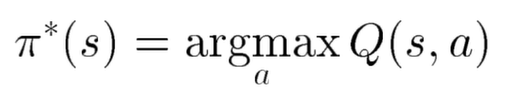

* q_table을 처음엔 0으로 초기화 하나, 미래에는 안다고 가정. 아래의 수식으로 Q를 반복해서 학습
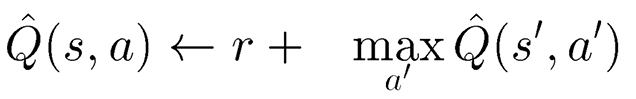


## 코드 개요
1. q_table 초기화

2. for문 : config에서 입력받은 episodes 중에서 episode 하나씩 학습

  2-1. while 문 : episode의 time step가 돌아가는 코드.
    * done은 terminate(지거나, time step이 끝나거나)와 truncated.

    2-2. Take action
      * 엡실론으로 탐험(Exploration)할지 활용(Exploition)할지 결정.
      * 엡실론의 값이 크면 새로운 정보를 얻기 위한 탐색을 많이 하므로 학습이 오래걸림.
      * Policy improvement
   
    2-3. Make observation

    2-4. Update Q given (2-3)

    2-5. t=t+1



* ***defaultdict***(): 딕셔너리를 만드는 dict 클래스의 서브 클래스. defaultdict()는 인자로 주어진 객체의 기본 값을 딕셔너리의 초기값으로 지정가능. ➡️ value값이 주어지지 않고, q_table['key']을 찾으면 0값으로 지정.




In [ ]:
import time
win_pct_QLearning = []

def q_learning(env, alpha, gamma, epsilon, episodes, alpha_decay_rate=0.99, performance_threshold=0.8):

    start_time = time.time()  # 학습 시작 시간
    scores = []

    # Q-table을 초기화하는 대신, 각 상태에 대한 dictionary를 사용합니다.
    # 이 경우 상태는 보드의 배열로 표현됩니다.
    q_table = defaultdict(lambda: np.zeros(env.action_space.n))

    alpha_decay_step=episodes # 학습률을 감소 시키기 시작할 에피소드 수

    for i in range(episodes):
        state =np.array(env.reset()).flatten()  # 상태를 1차원 배열로 변환합니다.
        score = 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # 탐색(Exploration): 무작위 액션 -> 새로운 정보를 얻는 과정
            else:
                action = np.argmax(q_table[tuple(state)])  # 활용(Expolition): 학습된 값 활용하여 최적의 행동을 선택 -> # Policy를 improvment

            next_state, reward, done, _ = env.step(action)
            next_state = np.array(next_state).flatten() # 다음 상태도 1차원 배열로 변환합니다.
            score += reward

            old_value = q_table[tuple(state)][action]
            next_max = np.max(q_table[tuple(next_state)])

            # Q(S,A)를 업데이트
            new_value = old_value + alpha * (reward + gamma * next_max - old_value)
            q_table[tuple(state)][action] = new_value

            state = next_state  # 상태 업데이트

        scores.append(score)

        if (i + 1) % alpha_decay_step == 0:
            alpha *= alpha_decay_rate  # 학습률 감소

        if (i + 1) % 100 == 0: #하나의 에피소드가 끝나고 평균 보상값
            recent_average_reward = np.mean(scores[-100:])
            win_pct_QLearning.append(recent_average_reward)
            print(f"Episode: {i + 1}, Average Reward: {recent_average_reward}")
            if recent_average_reward > performance_threshold:
                print("성능 기준에 도달하여 학습을 조기 종료합니다.")
                break

    end_time = time.time()  # 학습 종료 시간
    total_time = end_time - start_time
    print(f"Total training time: {total_time} seconds")

    return q_table


In [ ]:
# Q-Table 학습

q_table = q_learning(env_2, alpha, gamma, epsilon, episodes)
#q_table= q_learning(env_2, alpha=0.1, gamma=0.9, epsilon=0.5, episodes=10000)
# 학습된 Q-Table 출력
print(f"Trained Q-Table: \n{q_table}")

Episode: 100, Average Reward: -3.2771428571428567
Episode: 200, Average Reward: -2.109047619047619
Episode: 300, Average Reward: -2.7252380952380952
Episode: 400, Average Reward: -2.210952380952381
Episode: 500, Average Reward: -2.1490476190476193
Episode: 600, Average Reward: -3.158809523809524
Episode: 700, Average Reward: -2.1814285714285715
Episode: 800, Average Reward: -2.6511904761904765
Episode: 900, Average Reward: -3.1130952380952386
Episode: 1000, Average Reward: -2.2366666666666672
Episode: 1100, Average Reward: -2.0980952380952385
Episode: 1200, Average Reward: -3.0723809523809518
Episode: 1300, Average Reward: -2.9571428571428573
Episode: 1400, Average Reward: -3.2347619047619047
Episode: 1500, Average Reward: -2.8780952380952387
Episode: 1600, Average Reward: -2.544047619047619
Episode: 1700, Average Reward: -3.0576190476190472
Episode: 1800, Average Reward: -2.5583333333333336
Episode: 1900, Average Reward: -3.981666666666667
Episode: 2000, Average Reward: -2.06119047619

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
get_win_percentages_trained(env_2,q_table, "random", 100)  # 랜덤 에이전트와의 대결

Trained Agent Win Percentage: 0.0
Agent 2 Win Percentage: 0.0


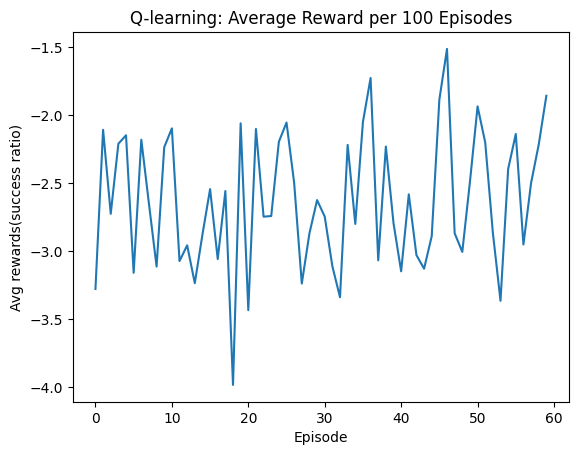

In [ ]:
plt.plot(win_pct_QLearning)
plt.xlabel('Episode')
plt.ylabel('Avg rewards(success ratio)')
plt.title('Q-learning: Average Reward per 100 Episodes')
plt.show()


### 결과 분석

여러번 시행하였는데 2가지 그래프가 나왔습니다.

1. 초기 변동성이 큰 그래프 경우
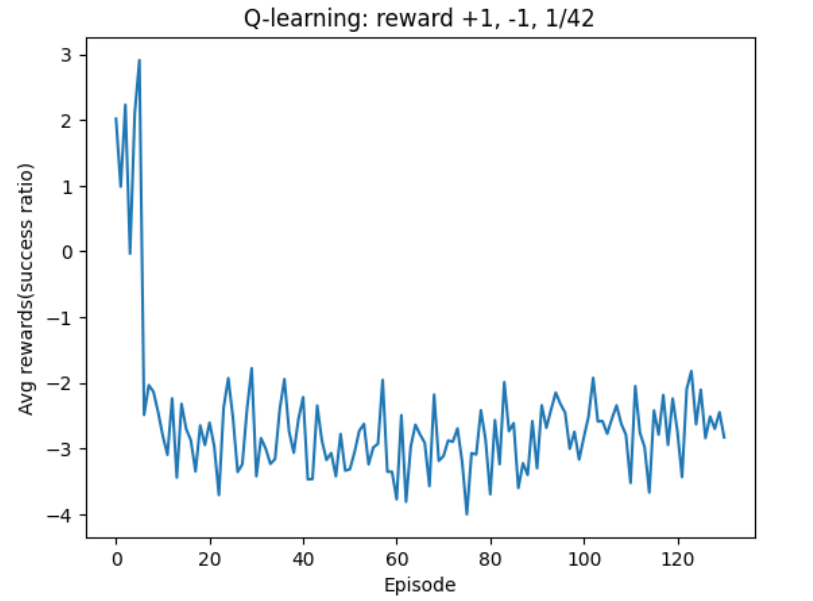

 처음보다 안정적인 추세를 보이지만 전체 reward가 음수임을 보여주므로 Q-learning으로의 학습은 성능이 좋지 않음을 결론 지을 수 있다.

* 시작 부분에 결과가 급격하게 양수이다가 떨어진 것을 보아 에이전트가 처음에 환경을 탐색하고 초기 전략을 배우는 과정이라고 판단할 수 있었습니다.

* 원래 kaggle의 ConnectFourGym 문제는 보상 체계가 다음과 같습니다.
  * 나의 agent 승리: + 1
  * 상대방 agent 승리: -1
  * 그 외 경우: 1/42


2. reward 보상 체계를 바꾼 후 그래프
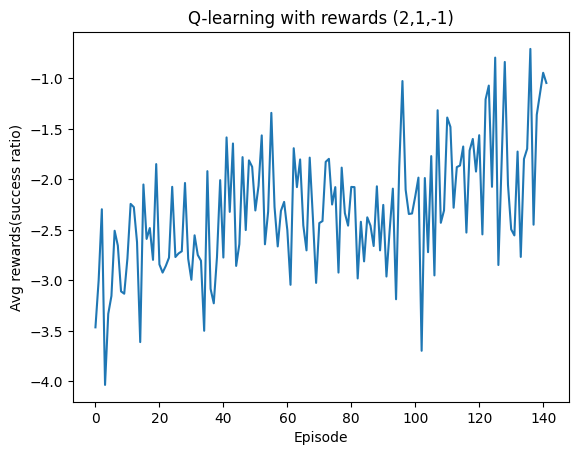

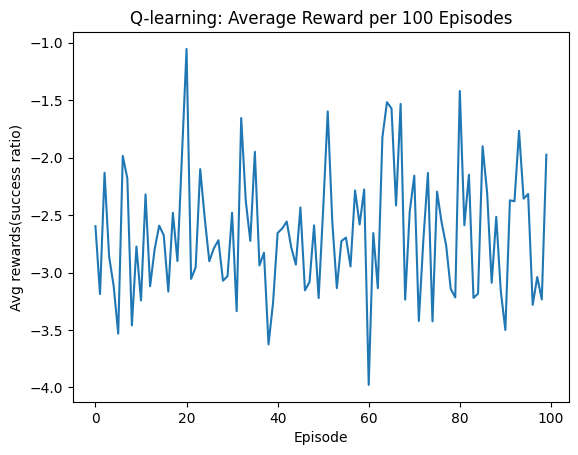

* reward가 패배와 승리 시의 차이가 별로 없어 성능이 좋지 않을까 생각하여 나의 agent 승리 시에 값을 10으로 극단적으로 설정하였을 때, 양수의 점수가 나왔으나 에피소드가 100번 정도만 돌고 조기 종료하여 학습이 조금밖에 안되고 과적합 문제가 생겼음.
-> 극단적인 격차로 보상 체계의 편향이 생겼음.

* 또한, 너무 오랜 시간 동안 학습을 하여 quick wins을 위하여 그 외 경우를 1/42가 아닌 -0.1로 약간의 패널티를 주기로 하였음.

In [ ]:
# Q-Table 학습
#q_table_3= q_learning(env_3, alpha=0.5, gamma=0.9, epsilon=0.1, episodes=10000, performance_threshold=0.9)
# 학습된 Q-Table 출력
#print(f"Trained Q-Table: \n{q_table_3}")



Episode: 100, Average Reward: -2.3209999999999997
Episode: 200, Average Reward: -1.6439999999999995
Episode: 300, Average Reward: -2.8560000000000008
Episode: 400, Average Reward: -2.64
Episode: 500, Average Reward: -1.7789999999999997
Episode: 600, Average Reward: -2.5009999999999994
Episode: 700, Average Reward: -1.811
Episode: 800, Average Reward: -1.8750000000000002
Episode: 900, Average Reward: -2.307
Episode: 1000, Average Reward: -2.063
Episode: 1100, Average Reward: -1.5639999999999998
Episode: 1200, Average Reward: -2.6420000000000003
Episode: 1300, Average Reward: -2.3179999999999996
Episode: 1400, Average Reward: -1.341
Episode: 1500, Average Reward: -2.2720000000000002
Episode: 1600, Average Reward: -2.6629999999999994
Episode: 1700, Average Reward: -2.311
Episode: 1800, Average Reward: -2.222
Episode: 1900, Average Reward: -2.501
Episode: 2000, Average Reward: -3.0429999999999997
Episode: 2100, Average Reward: -1.6909999999999998
Episode: 2200, Average Reward: -2.076
Episo

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



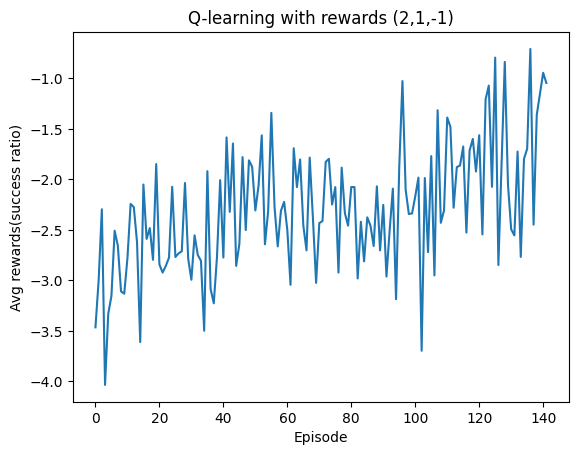

In [ ]:
#plt.plot(win_pct_QLearning)
#plt.xlabel('Episode')
#plt.ylabel('Avg rewards(success ratio)')
#plt.title('Q-learning with rewards (2,1,-1)')
#plt.show()

## SARSA

In [ ]:
win_pct_SARSA = []

def sarsa(env, alpha, gamma, epsilon, episodes):
    start_time = time.time()  # 학습 시작 시간
    scores = []

    q_table = defaultdict(lambda: np.zeros(env.action_space.n))

    for i in range(episodes): # i = episode, 하나의 episode에 대하여
        state = env.reset().flatten()
        score=0
        done = False

        #현재 state에서 선택한 action
        if random.uniform(0, 1) < epsilon: #탐험(Exploration)
            action = env.action_space.sample()
        else:                              #활용(Expolitation) -> Policy를 improvement
            action = np.argmax(q_table[tuple(state)])

        while not done: # time step마다 계산
            next_state, reward, done, _ = env.step(action)
            next_state = next_state.flatten()
            next_action = None #??
            score += reward

            #next action
            if random.uniform(0, 1) < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(q_table[tuple(state)]) #Policy를 improvement함.

            q_table[tuple(state)][action] += alpha * (reward + gamma * q_table[tuple(next_state)][next_action] - q_table[tuple(state)][action])

            state, action = next_state, next_action
        scores.append(score)

        if (i + 1) % 100 == 0: #100개 에피소드가 끝나고 평균 보상값
            recent_average_reward = np.mean(scores[-100:])
            win_pct_SARSA.append(recent_average_reward)
            print(f"Episode: {i + 1}, Average Reward: {recent_average_reward}")

    end_time = time.time()  # 학습 종료 시간
    total_time = end_time - start_time
    print(f"Total training time: {total_time} seconds")
    return q_table


In [ ]:
q_table_SARSA =  sarsa(env_2, alpha, gamma, epsilon, episodes)
#q_table_SARSA =  sarsa(env_2, alpha=0.5, gamma=0.9, epsilon=0.1, episodes=10000)
print(f"Trained Q-Table: \n{q_table_SARSA}")

Episode: 100, Average Reward: -2.7526190476190475
Episode: 200, Average Reward: -2.2097619047619053
Episode: 300, Average Reward: -2.018333333333333
Episode: 400, Average Reward: -2.5576190476190477
Episode: 500, Average Reward: -1.8259523809523808
Episode: 600, Average Reward: -2.791666666666666
Episode: 700, Average Reward: -1.5121428571428572
Episode: 800, Average Reward: -2.7642857142857142
Episode: 900, Average Reward: -2.13047619047619
Episode: 1000, Average Reward: -1.8207142857142857
Episode: 1100, Average Reward: -2.3473809523809526
Episode: 1200, Average Reward: -2.4378571428571423
Episode: 1300, Average Reward: -1.5095238095238097
Episode: 1400, Average Reward: -2.7899999999999996
Episode: 1500, Average Reward: -2.1540476190476188
Episode: 1600, Average Reward: -1.5678571428571428
Episode: 1700, Average Reward: -2.493809523809524
Episode: 1800, Average Reward: -1.3230952380952379
Episode: 1900, Average Reward: -1.8202380952380945
Episode: 2000, Average Reward: -1.68452380952

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
get_win_percentages_trained(env_2, q_table_SARSA, "random", 100)  # 예를 들어, 랜덤 에이전트를 상대로 승률을 계산합니다.

Trained Agent Win Percentage: 0.0
Agent 2 Win Percentage: 0.0


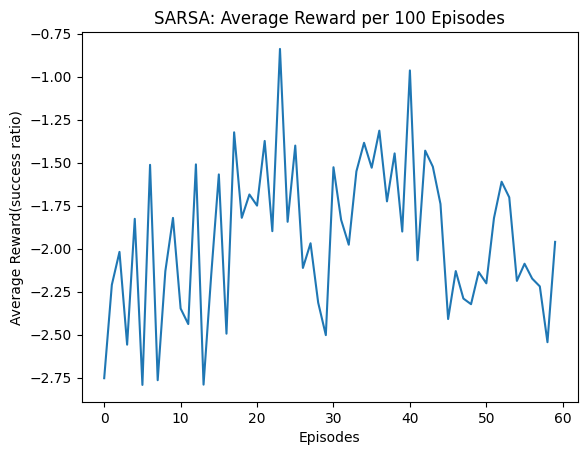

In [ ]:
plt.plot(win_pct_SARSA)
plt.xlabel('Episodes')
plt.ylabel('Average Reward(success ratio)')
plt.title('SARSA: Average Reward per 100 Episodes')
plt.show()



###결과 분석: q_learning과 비슷하게 전반적으로 음수의 평균 보상을 보여줘서 최적의 강화학습 이론임을 판단을 내렸다.

## DQN

* 파라미터 값 조절을 해도 계속된 세션 다운으로 학습 실패


In [ ]:
import tensorflow as tf
from collections import deque



class DQN:
    def __init__(self, env, epsilon, gamma, alpha, alpha_decay_rate=0.99, target_update_freq=1000, memory_size=5000):
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.alpha_decay_rate = alpha_decay_rate
        self.target_update_freq = target_update_freq

        self.memory = deque(maxlen=memory_size)
        self.target_network = self.build_q_network()
        self.q_network = self.build_q_network()

    def build_q_network(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=self.env.observation_space.shape),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(self.env.action_space.n)
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.alpha), loss='mse')
        return model

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Exploration
        else:
            q_values = self.q_network.predict(state)
            return np.argmax(q_values[0])  # Exploitation

    def update_epsilon(self, episode):
        self.epsilon *= self.alpha_decay_rate

    def replay_experience(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)

        states, targets = [], []
        for state, action, reward, next_state, done in batch:
            target = self.q_network.predict(state)
            if done:
                target[0][action] = reward
            else:
                target[0][action] = reward + self.gamma * np.max(self.target_network.predict(next_state)[0])
            states.append(state)
            targets.append(target)

        self.q_network.fit(np.vstack(states), np.vstack(targets), epochs=1, verbose=0)

    def train(self, episodes, batch_size, performance_threshold=0.8):
        scores = []
        win_pct_DQN = []
        update_counter = 0  # 학습 빈도 조정을 위한 카운터

        for episode in range(episodes):
            state = self.env.reset()
            state = np.reshape(state, (1,) + state.shape)
            score = 0
            done = False

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, (1,) + next_state.shape)
                score += reward

                self.memory.append((state, action, reward, next_state, done))
                state = next_state

                #if len(self.memory) > batch_size:
                #    self.replay_experience(batch_size)

                if len(self.memory) > batch_size:
                    update_counter += 1
                    if update_counter % 4 == 0:  # 매 4번째 스텝마다 학습
                      self.replay_experience(batch_size)


            scores.append(score)

            if (episode + 1) % self.target_update_freq == 0:
                self.target_network.set_weights(self.q_network.get_weights())

            self.update_epsilon(episode)

             # 매 100 에피소드마다 평균 보상을 계산하고 출력합니다.
            if (episode + 1) % 100 == 0:
                recent_average_reward = np.mean(scores[-100:])
                win_pct_DQN.append(recent_average_reward)
                print(f"Episode: {episode + 1}, Average Reward: {recent_average_reward}")

                # 성능 기준을 확인하지 않고 학습을 계속 진행합니다.
                if recent_average_reward > performance_threshold:
                    print("성능 기준에 도달하여 학습을 조기 종료합니다.")
                    break

        final_average_reward = np.mean(scores[-100:])
        print(f"Final Average Reward: {final_average_reward}")

        return self.q_network, win_pct_DQN


In [ ]:
print("Observation Space: ", env_2.observation_space)
print("Action Space: ", env_2.action_space)

# 속성의 타입과 shape을 검사합니다.
print("Type of Observation Space: ", type(env_2.observation_space))
print("Type of Action Space: ", type(env_2.action_space))
print("Shape of Observation Space: ", env_2.observation_space.shape)


Observation Space:  Box(0, 2, (1, 6, 7), int64)
Action Space:  Discrete(7)
Type of Observation Space:  <class 'gym.spaces.box.Box'>
Type of Action Space:  <class 'gym.spaces.discrete.Discrete'>
Shape of Observation Space:  (1, 6, 7)


In [ ]:
batch_size = 32

In [ ]:
dqn = DQN(env_2, epsilon, gamma, alpha)
q_network, win_pct_DQN = dqn.train(episodes, batch_size)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 30ms/step
Episode: 400, Average Reward: -1.5657142857142858
1/1 [==============================] - 0s 36ms/step


KeyboardInterrupt: ignored

In [ ]:
plt.plot(win_pct_DQN)
plt.xlabel('Episode')
plt.ylabel('Avg rewards(success ratio)')
plt.title('DQN')
plt.show()

NameError: ignored

## MC

In [ ]:
def monte_carlo_learning(env, episodes, gamma):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    V = defaultdict(float)
    win_pct_mc = []
    scores = []

    for episode in range(1, episodes + 1):
        episode_data = []
        state = env.reset()
        done = False
        score = 0

        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            episode_data.append((state, action, reward))
            score += reward
            state = next_state

        scores.append(score)

        if episode % 100 == 0:
            average_reward = np.mean(scores[-100:])
            win_pct_mc.append(average_reward)
            print(f"Episode: {episode}, Average Reward: {average_reward}")

        G = 0
        for state, action, reward in reversed(episode_data):
          G = gamma * G + reward
          state_tuple = tuple(state.flatten())  # 다차원 배열을 일차원 배열로 변환하고 튜플로 변환
          if not any(np.array_equal(state, x[0]) for x in episode_data[:-1]):
              returns_sum[state_tuple] += G
              returns_count[state_tuple] += 1.0
              V[state_tuple] = returns_sum[state_tuple] / returns_count[state_tuple]

    return V, win_pct_mc, scores


In [ ]:
V, win_pct_mc, scores = monte_carlo_learning(env_2, episodes, gamma)


Episode: 100, Average Reward: -1.8504761904761904
Episode: 200, Average Reward: -2.2397619047619046
Episode: 300, Average Reward: -1.8383333333333334
Episode: 400, Average Reward: -1.8283333333333334
Episode: 500, Average Reward: -1.433809523809524
Episode: 600, Average Reward: -1.3621428571428569
Episode: 700, Average Reward: -2.072380952380952
Episode: 800, Average Reward: -2.2745238095238096
Episode: 900, Average Reward: -1.8585714285714285
Episode: 1000, Average Reward: -2.158571428571429
Episode: 1100, Average Reward: -1.5273809523809525
Episode: 1200, Average Reward: -2.0895238095238096
Episode: 1300, Average Reward: -2.104047619047619
Episode: 1400, Average Reward: -2.013333333333333
Episode: 1500, Average Reward: -2.852619047619047
Episode: 1600, Average Reward: -1.7923809523809522
Episode: 1700, Average Reward: -1.7935714285714284
Episode: 1800, Average Reward: -1.9916666666666663
Episode: 1900, Average Reward: -1.6535714285714282
Episode: 2000, Average Reward: -2.174523809523

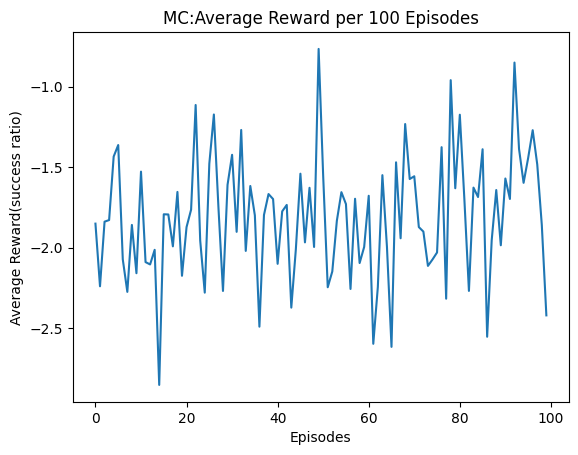

In [ ]:
plt.plot(win_pct_mc)
plt.title("MC:Average Reward per 100 Episodes")
plt.xlabel("Episodes")
plt.ylabel("Average Reward(success ratio)")
plt.show()

결과 분석:
SARSA와 Q_learning와 비슷하게 음의 보상값을 가지지만 -4와 -3까지 보상 평균을 보여주는 이전 결과와 비교적 다소 안정적인 범위이다. 하지만 여전히 10000개의 에피소드를 학습했지만 좋지 않는 성능을 보여주어 이 문제를 푸는데 적합한 알고리즘은 아니다.

# 결과

Connect Four 게임에서 강화학습 알고리즘을 사용할 때, 일반적으로 게임의 환경(보드의 상태)은 알고 있다고 가정합니다. 이는 에이전트가 게임 보드의 현재 상태를 완전하게 관찰할 수 있으며, 어떤 행동을 선택할 때 가능한 결과(어느 위치에 돌을 놓을지)를 알고 있다는 것을 의미합니다.

* 에이전트는 모든 가능한 state 확인, 각 action이 어떤 결과를 초래할지 안다.

* agent가 특정 간에 돌을 놓으면, action이 갑자기 바뀌지 않으므로 deterministic하다.

<참고>
* DQN으로 학습을 시킬려 했으나 거듭된 세션 다운으로 하지 못하였음.

### 1. Q-learning
* 게임은 상대 agent에 따라 능동적으로 대응을 해야하는 것이므로 에피소드 중에서 학습할 수 있는 Q-learning을 이용하였다. 하지만 q-learning은 결정론적인 환경에서는 안정적인 학습이 가능하지만 off-policy으로 target policy와 behavior policy가 일치 하지 않아 상대방이 deterministic하게 항상 같은 방식으로 action을 두지 않는 이상 좋은 성능을 내기가 힘들다.

* q-learning은 q_table의 최대 보상 기반으로 가치를 업데이트 하는데 이는 단기적인 최적화(behavior policy)에 치우질 수 있었지만 정작 최종 목표인 승리까지는 고려를 못하는 문제로 음수의 reward를 가지게 되었다.

### 2. SARSA
Q_learning보다 수렴이 빠르다. 또한 optimal policy가 될 policy인 현재 정책에 따라 학습(on policy)하여 단기적으로 그리디하게 움직이지는 않지만 실제 플레이어처럼 승률을 위한 학습을 하도록 하기 위해 사용하였다. 하지만 play 중에 발생하는 실제 결과를 기반으로 Value function을 업데이트 하므로 안정적인 결과였지만 지나치게 보수적이라 q_learning과 같은 이유로 상대 agent에 대해 대응을 잘 못하여 성능이 좋지 않았음.

### 3. Monte Carlo
* 먼저 MC는 하나의 에피소드가 끝나야 가치 함수를 업데이트 한다. 이는 상대가 수를 어떻게 두는지 에따라 능동적으로 대응을 못해서 성능이 낮게 나올 수 밖에 없는 강화학습 이론이다. * 그래서 다른 SARSA나 Q_learning에 비해 단기적인 피드백이 없어 보수적이고 매우 느리게 결과를 반환하였다.


### 4. DQN
* 세션 다운으로 결과를 보지 못하였지만 가장 성능이 좋을거라 판단한 알고리즘임.
* 신경망을 이용하여 큰 State를 다룰 수 있고, 복잡한 전략을 학습할 가능성이 높아 이용하고 자하였음.
* 하지만 파라미터 튜닝에 있어 어려움을 겪고 몇번 세션이 다운되어 결과를 도출하지는 못함.


6x7 보드판에서 가로,세로,양의 대각선,음의 대각선 빙고로 작동하도록 해야하는데, MC,SARSA,Q-learning은 방대한 state 공간과 복잡한 전략을 다루지 못하여 양의 보상 결과를 반환하지 못한 것으로 추정됩니다. 하지만 DQN을 이용하여 깊은 신경망으로 가치 함수를 근사하였다면 복잡한 전략 게임에서 효과적으로 좋은 성능을 낼거라 추정합니다.




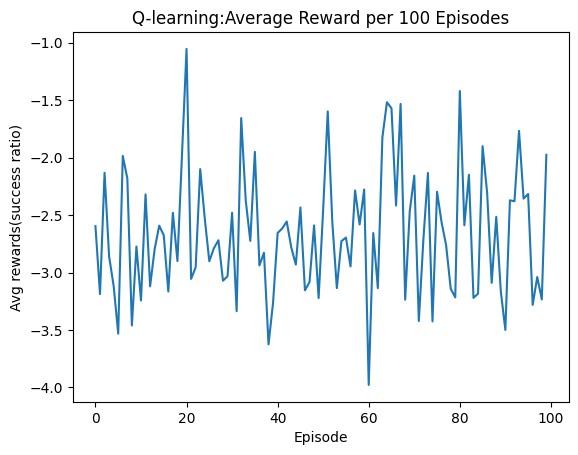

In [ ]:
plt.plot(win_pct_QLearning)
plt.xlabel('Episode')
plt.ylabel('Avg rewards(success ratio)')
plt.title('Q-learning:Average Reward per 100 Episodes')
plt.show()



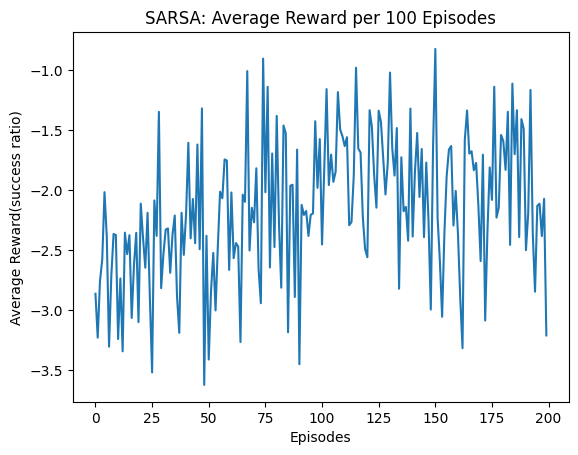

In [ ]:
plt.plot(win_pct_SARSA)
plt.xlabel('Episodes')
plt.ylabel('Average Reward(success ratio)')
plt.title('SARSA: Average Reward per 100 Episodes')
plt.show()

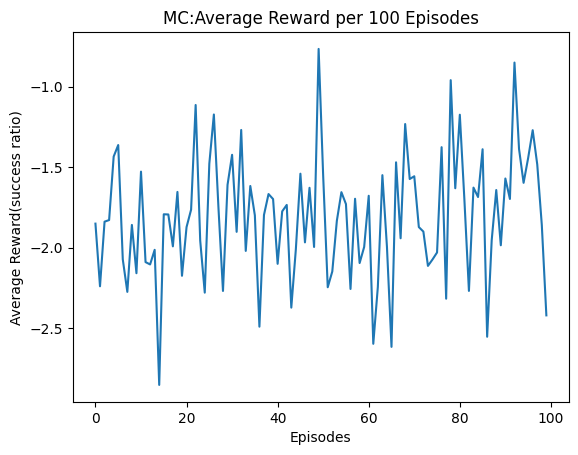

In [ ]:
plt.plot(win_pct_mc)
plt.title("MC:Average Reward per 100 Episodes")
plt.xlabel("Episodes")
plt.ylabel("Average Reward(success ratio)")
plt.show()